In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.transforms import ToTensor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Defining the Model

In [133]:
class SoftMaxNeuralNetwork(nn.Module):
    def __init__(self, input_size: int):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.layers(x)
    
    def clasiffy(self, x):
        return torch.argmax(self.forward(x), dim=1)
    
class SigmoidNeuralNetwork(nn.Module):
    def __init__(self, input_size: int):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.layers(x).view(-1)
    
    def clasiffy(self, x):
        return torch.round(nn.Sigmoid()(self.forward(x))).view(-1)

#### Loading the Data

In [134]:
def load_data(n: int):
    X = np.load('Datasets/kryptonite-%s-X.npy'%(n))
    y = np.load('Datasets/kryptonite-%s-y.npy'%(n))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_test, y_test


def convert_to_tensor_dataset(X, y):
    return torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.float32).to(device))

In [135]:
n = 18

X_train, y_train, X_test, y_test = load_data(n)

In [136]:
train_dataset = convert_to_tensor_dataset(X_train, y_train)

#### Hyperparameter tunning functions

In [137]:
def k_fold(train_dataset, num_folds, num_epochs, learning_rate, batch_size, weight_decay, model_type, verbose=False):
    assert model_type == 'softmax' or model_type == 'sigmoid'

    kfold = KFold(n_splits=num_folds, shuffle=True)

    if verbose:
        print('Starting k-fold cross validation')
        print('---------------------------------------')

    fold_no = 0
    fold_accs = []

    for train_index, validation_index in kfold.split(train_dataset):
        
        fold_no += 1

        if verbose:
            print('Training on fold:', fold_no)

        if model_type == 'softmax':
            net = SoftMaxNeuralNetwork(n).to(device)
            loss_fn = nn.CrossEntropyLoss()
        else:
            net = SigmoidNeuralNetwork(n).to(device)
            loss_fn = nn.BCEWithLogitsLoss()
            
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(validation_index)

        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, sampler=validation_subsampler)

        epoch_losses = []
        for epoch in range(num_epochs):

            epoch_train_loss = []
            for i, (inputs, labels) in enumerate(trainloader):
                net.zero_grad()
                outputs = net(inputs)
                if model_type == 'softmax':
                    labels = labels.long()
                loss = loss_fn(outputs, labels)
                epoch_train_loss.append(loss.item())
                loss.backward()
                optimizer.step()
            
            if epoch % 5 == 0 and verbose:
                print('Epoch:', epoch + 1, 'Loss:', np.mean(epoch_train_loss))
            
            epoch_losses.append(np.mean(epoch_train_loss))

        with torch.no_grad():
            accuracies = []
            for _, (inputs, labels) in enumerate(validationloader):
                outputs = net.clasiffy(inputs)
                acc = np.mean(outputs.cpu().numpy() == labels.cpu().numpy())
                accuracies.append(acc.item())
            fold_accs.append(np.mean(accuracies))
    
    if verbose:
        print('---------------FINISHED----------------')
        print('Accuracies:', fold_accs)
        print('Average accuracy:', np.mean(fold_accs))

    return epoch_losses, np.mean(fold_accs)
                

In [138]:
def grid_search(train_dataset, num_folds, num_epochs, lrs: list, batch_sizes: list, regs: list, model_types: list, verbose=False):
    result_map = dict()
    
    trainings = []
    names = []

    for lr in lrs:
        for batch_size in batch_sizes:
            for reg in regs:
                for model_type in model_types:
                    train_losses, accs = k_fold(train_dataset, num_folds, num_epochs, lr, batch_size, reg, model_type, verbose)
                    model_name = f"{model_type} model, Learning Rate {lr}, Batch Size {batch_size}, Regularization {reg}"
                    result_map[model_name] = accs

                    trainings.append(train_losses)
                    names.append(model_name)

    if verbose:
        for i, name in enumerate(names):
            plt.plot(trainings[i], label=name)
        plt.legend()
        plt.show()
    
    sorted_models = [key for key, value in sorted(result_map.items(), key=lambda item: item[1], reverse=True)]
    
    print(sorted_models[:2])

    return result_map

Starting k-fold cross validation
---------------------------------------
Training on fold: 1
Epoch: 1 Loss: 0.6936751008033752
Epoch: 6 Loss: 0.6904728078842163
Epoch: 11 Loss: 0.6874904417991639
Epoch: 16 Loss: 0.6840282964706421
Epoch: 21 Loss: 0.6797678017616272
Epoch: 26 Loss: 0.6743364644050598
Epoch: 31 Loss: 0.6701223587989807
Epoch: 36 Loss: 0.6657939624786376
Epoch: 41 Loss: 0.6603344893455505
Epoch: 46 Loss: 0.6539196968078613
Epoch: 51 Loss: 0.6504382586479187
Epoch: 56 Loss: 0.6474314570426941
Epoch: 61 Loss: 0.6411539435386657
Epoch: 66 Loss: 0.6371542286872863
Epoch: 71 Loss: 0.6333199334144592
Epoch: 76 Loss: 0.6267808485031128
Epoch: 81 Loss: 0.6243165564537049
Epoch: 86 Loss: 0.6243364572525024
Epoch: 91 Loss: 0.6151024007797241
Epoch: 96 Loss: 0.6127538704872131
Epoch: 101 Loss: 0.6062363910675049
Epoch: 106 Loss: 0.6007152581214905
Epoch: 111 Loss: 0.5968473052978516
Epoch: 116 Loss: 0.5924509716033936
Epoch: 121 Loss: 0.5886880707740784
Epoch: 126 Loss: 0.5834762716

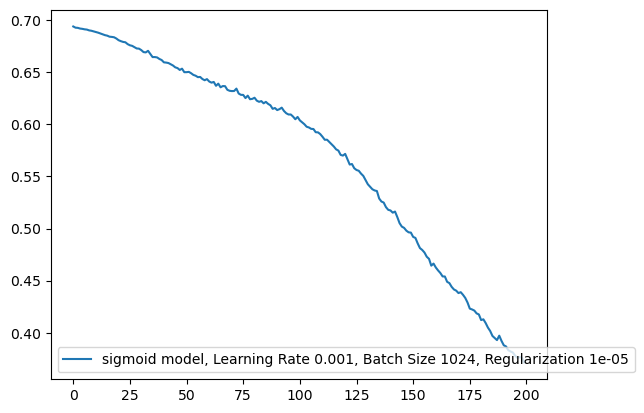

['sigmoid model, Learning Rate 0.001, Batch Size 1024, Regularization 1e-05']


In [141]:
results =  grid_search(train_dataset=train_dataset, num_folds=7, num_epochs=200, 
            lrs=                [0.001], 
            batch_sizes=        [1024], 
            regs=               [1e-5], 
            model_types=        ['sigmoid'],
            verbose=True)

In [140]:
def train_and_test(n, train_dataset, test_dataset, num_epochs):
    net = NeuralNetwork(n)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

    training_losses = []

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)

    for epoch in range(num_epochs):
        epoch_train_loss = []
        for i, (inputs, labels) in enumerate(trainloader):
            net.zero_grad()
            
            outputs = net(inputs)
            loss = loss_fn(outputs, labels.long())
            epoch_train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        
        print('Epoch:', epoch + 1, 'Loss:', np.mean(epoch_train_loss))
        training_losses.append(np.mean(epoch_train_loss))

    with torch.no_grad():
        losses = []
        for i, (inputs, labels) in enumerate(testloader):
            outputs = net.clasiffy(inputs)
            loss = np.mean(outputs.numpy() == labels.numpy())
            losses.append(loss.item())
        print('Test accuracy:', np.mean(losses))

    return training_losses, np.mean(losses)